In [12]:
import numpy as np
import time
from tkinter import *

# Parameters

N_part = 250
L = 80.0                # arena [-L/2, L/2]
v = 0.5                 # velocity
dt = 1.0
eta = 0.03              # noise in direction
Rf = 1.0                # collision/interaction radius
cluster_range = 1.2 * Rf
infection_radius = Rf

N_max_steps = 10000
N_skip = 1              

# Brownsk diffusion
d_move = 0.3            # probability that particle diffuses this step
sigma = 0.05            # std for brownian displacement

# SIR-like parameters
I0 = 5                 # initially infected

# Number of special particles
N_HSP104 = 5
N_HEAL   = 30          # HSP70
N_DEATH  = 5

# Biologically significant parameters
Kd_HSP70 = 1.8e-4         # "affinity" HSP70
k_agg    = 0.01          # aggregation rate constant (arbitrary scale)
volume_conversion = 1.0 # area→concentration 

p_infected_drag = 0.5   # probability that HSP104 actually drags along an infected
carry_duration  = 10    # how many steps HSP104 carries an infected

p_death = 0.5           # probability that DEATH + infected contact leads to death
beta_alpha_syn = 0.02   # biologically motivated per-contact chance

# diameters
diam_alpha_syn = 10
diam_hsp70     = 7
diam_hsp104    = 12
diam_death     = 9

# Scale nm → "arena unit" (as in your code 2)
scale_nm_to_units = 0.6

# Radii in simulation units 
radius_alpha_syn = (diam_alpha_syn / 2) * scale_nm_to_units
radius_hsp70     = (diam_hsp70     / 2) * scale_nm_to_units
radius_hsp104    = (diam_hsp104    / 2) * scale_nm_to_units
radius_death     = (diam_death     / 2) * scale_nm_to_units

# Global cluster structures
clusters   = []                         # list of lists (member indices)
cluster_id = -1 * np.ones(N_part, dtype=int) # -1 = not in cluster


following_hsp = {}

# FFor potential future blocking of rapid re-clustering
no_cluster_until = -1 * np.ones(N_part, dtype=int)


In [13]:
import numpy as np
def pbc(x, y, L):
    """Periodic boundary conditions."""
    outside_left = np.where(x < -L / 2)[0]
    x[outside_left] += L

    outside_right = np.where(x > L / 2)[0]
    x[outside_right] -= L

    outside_up = np.where(y > L / 2)[0]
    y[outside_up] -= L

    outside_down = np.where(y < -L / 2)[0]
    y[outside_down] += L

    return x, y


def minimum_image(dx, L):
    """Minimum image convention for 1D distances."""
    return dx - L * np.round(dx / L)

def pbc_single(x_val, y_val, L):
    """Periodic boundary conditions for a single particle."""
    x_arr, y_arr = pbc(np.array([x_val]), np.array([y_val]), L)
    return x_arr[0], y_arr[0]


In [14]:
def create_cluster(members):
    global clusters, cluster_id
    members = np.unique(np.asarray(members, dtype=int)).tolist()
    if len(members) < 2:
        return None
    cid = len(clusters)
    clusters.append(members)
    for m in members:
        cluster_id[m] = cid
    return cid


def add_members_to_cluster(cid, members):
    global clusters, cluster_id
    members = np.unique(np.asarray(members, dtype=int)).tolist()
    new_members = [m for m in members if m not in clusters[cid]]
    if len(new_members) == 0:
        return
    clusters[cid].extend(new_members)
    for m in new_members:
        cluster_id[m] = cid


def merge_clusters(cid_a, cid_b):
    """Merge clusters cid_a and cid_b, adjusting cluster_id safely."""
    global clusters, cluster_id
    
    if cid_a == cid_b:
        return cid_a

    a, b = sorted([cid_a, cid_b])

    members = list(set(clusters[a]) | set(clusters[b]))
    clusters[a] = members

    for m in members:
        cluster_id[m] = a

    clusters.pop(b)

    # Shift down indices > b by 1
    for i in range(len(cluster_id)):
        if cluster_id[i] > b:
            cluster_id[i] -= 1

    # Safeguard
    cluster_id[cluster_id >= len(clusters)] = -1

    return a


def remove_from_cluster(cid, members):
    global clusters, cluster_id
    if cid == -1:
        return
    if isinstance(members, int):
        members = [members]
    for m in members:
        if m in clusters[cid]:
            clusters[cid].remove(m)
            cluster_id[m] = -1
    if len(clusters[cid]) == 0:
        clusters[cid] = []


In [15]:
def collision_bounce(x, y, theta, Rf, L, alive_idx):
    """
    Simple elastic collision: two particles swap directions so they point away from each other.
    Cluster members do not bounce off each other (they stay together).
    """
    theta_new = np.copy(theta)

    # Build pairs in the same cluster that we will ignore
    cluster_pairs = set()
    for c in clusters:
        for i in c:
            for j in c:
                if i != j:
                    cluster_pairs.add((i, j))

    # Go through all alive pairs
    for ii, i in enumerate(alive_idx[:-1]):
        for j in alive_idx[ii+1:]:
            if (i, j) in cluster_pairs or (j, i) in cluster_pairs:
                continue

            dx = minimum_image(x[i] - x[j], L)
            dy = minimum_image(y[i] - y[j], L)

            if dx*dx + dy*dy <= Rf**2:
                theta_new[i] = np.arctan2(y[i] - y[j], x[i] - x[j])
                theta_new[j] = np.arctan2(y[j] - y[i], x[j] - x[i])

    return theta_new


In [16]:
def compute_clusters_from_contacts(x, y, infected_idx, cluster_range, L, status):
    infected_idx = np.asarray(infected_idx, dtype=int)

    clusters_local = []
    cluster_id_local = -1 * np.ones(len(x), dtype=int)
    visited = set()

    for i in infected_idx:
        if i in visited or status[i] == -1:
            continue

        q = [i]
        visited.add(i)
        comp = []

        while q:
            u = q.pop()
            comp.append(u)

            for v in infected_idx:
                if v in visited or status[v] == -1:
                    continue

                dx = minimum_image(x[v] - x[u], L)
                dy = minimum_image(y[v] - y[u], L)

                if dx*dx + dy*dy <= cluster_range**2:
                    visited.add(v)
                    q.append(v)

        if len(comp) >= 2:
            clusters_local.append(comp)
            for m in comp:
                cluster_id_local[m] = len(clusters_local) - 1

    return clusters_local, cluster_id_local


def interaction_infected_clustering(x, y, theta, Rf, L, infected_idx, cluster_range, status):
    """
    Build clusters of infected and set common theta for each cluster.
    """
    global clusters, cluster_id

    theta_next = np.copy(theta)

    clusters, cluster_id = compute_clusters_from_contacts(
        x, y, infected_idx, cluster_range, L, status
    )

    for members in clusters:
        if len(members) < 2:
            continue
        m = np.array(members, dtype=int)
        av_sin = np.mean(np.sin(theta[m]))
        av_cos = np.mean(np.cos(theta[m]))
        theta_next[m] = np.arctan2(av_sin, av_cos)

    return theta_next


In [17]:
def local_concentration(idx, x, y, R, L):
    """
    Compute "local concentration" around particle idx within radius R.
    Returns unit ~ mol/L but we keep it dimensionless via volume_conversion.
    """
    dx = x - x[idx]
    dy = y - y[idx]
    dx = minimum_image(dx, L)
    dy = minimum_image(dy, L)
    d2 = dx*dx + dy*dy
    neighbors = np.where(d2 < R**2)[0]
    area = np.pi * R**2
    conc = len(neighbors) / area * volume_conversion
    return conc


def infection_spread_bio(x, y, status, infected_idx,
                         infection_radius, dt, L, HSP104_idx, HEAL_idx, DEATH_idx):
    """
    Infection spread by local concentration around infected.
    Probability ~ 1 - exp(-k_agg * [monomer]^2 * dt)
    plus a baseline factor beta.
    """
    N = len(status)
    all_idx = np.arange(N)

    # remove special particles from "susceptible"
    protected = np.zeros(N, dtype=bool)
    protected[HSP104_idx] = True
    protected[HEAL_idx]   = True
    protected[DEATH_idx]  = True

    susceptible_idx = np.where((status == 0) & (~protected))[0]

    for i in infected_idx:
        conc_i = local_concentration(i, x, y, infection_radius, L)
        if conc_i <= 0:
            continue

        dx_all = x[susceptible_idx] - x[i]
        dy_all = y[susceptible_idx] - y[i]
        dx_all = minimum_image(dx_all, L)
        dy_all = minimum_image(dy_all, L)
        dist2 = dx_all**2 + dy_all**2

        close_idx = susceptible_idx[dist2 < infection_radius**2]

        for s in close_idx:
            # aggregation-based rate
            rate = k_agg * conc_i**2
            p_agg = 1.0 - np.exp(-rate * dt)

            # combine with "beta" (max 1)
            p_inf = min(1.0, beta_alpha_syn + p_agg)

            if np.random.rand() < p_inf:
                status[s] = 1

    infected_idx = np.where(status == 1)[0]

    return status


In [18]:
def HSP104_dissociation(theta, x, y, HSP104_idx, infected_idx,
                        HSP104_timer, max_dissociation_time,
                        p_infected_drag, Rf, L, step):
    """
    HSP104 can pick up an infected nearby (within Rf).
    """
    global following_hsp

    for h in HSP104_idx:
        if h in following_hsp:
            continue  # already following someone

        if len(infected_idx) == 0:
            continue

        dx = minimum_image(x[infected_idx] - x[h], L)
        dy = minimum_image(y[infected_idx] - y[h], L)
        dist2 = dx**2 + dy**2
        close_idx = infected_idx[dist2 <= Rf**2]

        if close_idx.size > 0 and np.random.rand() < p_infected_drag:
            i = close_idx[0]  # pick an infected
            following_hsp[h] = (i, step)  # (infected, start_step)
            HSP104_timer[h] = step
        else:
            # small random kick when not finding one
            theta[h] += (np.random.rand() - 0.5) * np.pi
            HSP104_timer[h] = step

    return theta


def update_following_hsp(theta, x, y, v, L, step, carry_duration=10):
    """
    Move HSP104 with the infected they carry and release infected after carry_duration steps.
    After separation, a small random kick is given.
    """
    global following_hsp

    if not following_hsp:
        return theta

    to_remove = []

    for h, (i, start_step) in list(following_hsp.items()):
        # Move infected with HSP104
        x[i] = x[h]
        y[i] = y[h]

        # Check if carry_duration has been reached
        if step - start_step >= carry_duration:
            to_remove.append(h)

    # Separate after carry_duration
    for h in to_remove:
        i, _ = following_hsp[h]
        del following_hsp[h]

        # Small separation
        sep = 0.3
        angle = np.random.rand() * 2 * np.pi
        x[h] += sep * np.cos(angle)
        y[h] += sep * np.sin(angle)
        x[i] -= sep * np.cos(angle)
        y[i] -= sep * np.sin(angle)

        # random theta
        theta[h] += (np.random.rand() - 0.5) * np.pi
        theta[i] += (np.random.rand() - 0.5) * np.pi

        # Periodic boundaries for these two particles
        x[h], y[h] = pbc_single(x[h], y[h], L)
        x[i], y[i] = pbc_single(x[i], y[i], L)

    return theta



In [19]:
def HEAL_interaction_bio(x, y, theta, HEAL_idx, status,
                         cluster_id, Rf, L, dt):
    """
    HEAL/HSP70:
    Heal infected not in cluster (cluster_id == -1).
    """
    theta_next = np.copy(theta)

    # Disaggregation constant from Schneider et al. 2021 (Hsc70+DnaJB1+Apg2)
    k_heal = 1.8e-4  # s^-1

    # Assume that a "contact step" in the simulation corresponds to ~1 minute of effective contact
    effective_contact_time = 300.0  # seconds

    # Per-contact probability of healing
    p_bind = 1.0 - np.exp(-k_heal * effective_contact_time)

    for h in HEAL_idx:
        # infected not in cluster
        free_reds = np.where((status == 1) & (cluster_id == -1))[0]
        if len(free_reds) == 0:
            continue

        dx = x[free_reds] - x[h]
        dy = y[free_reds] - y[h]
        dx = minimum_image(dx, L)
        dy = minimum_image(dy, L)
        dist2 = dx**2 + dy**2

        close_idx = free_reds[dist2 < Rf**2]

        for i in close_idx:
            if np.random.rand() < p_bind:
                # Heal infected → healthy
                status[i] = 0
                cluster_id[i] = -1

                # Small separation to avoid "sticking"
                sep = 0.5
                angle = np.random.rand() * 2 * np.pi
                x[i] += sep * np.cos(angle)
                y[i] += sep * np.sin(angle)
                x[i], y[i] = pbc_single(x[i], y[i], L)

                # random theta
                theta[i] = np.random.rand() * 2 * np.pi

    return theta_next, status


In [20]:
def DEATH_interaction(x, y, theta, DEATH_idx, status,
                      cluster_id, following_hsp, Rf, L, HSP104_idx, p_death):
    """
    DEATH-particles:
    - Kill infected that are alone or carried by HSP104.
    - Do not kill HSP104 or other DEATH.
    """
    theta_next = np.copy(theta)

    carried = np.array([v[0] for v in following_hsp.values()], dtype=int) \
              if following_hsp else np.array([], dtype=int)

    for d in DEATH_idx:
        killed = False

        for i in np.where(status == 1)[0]:
            if i in HSP104_idx or i in DEATH_idx:
                continue
            if cluster_id[i] != -1 and i not in carried:
                continue

            dx = minimum_image(x[i] - x[d], L)
            dy = minimum_image(y[i] - y[d], L)

            if dx*dx + dy*dy < Rf**2:
                if np.random.rand() < p_death:
                    status[i] = -1
                    cluster_id[i] = -1
                    x[i] = 10 * L
                    y[i] = 10 * L
                    killed = True
                    break
                else:
                    theta_next[d] = np.arctan2(-dy, -dx)

        if not killed:
            # collision against first alive particle nearby
            alive_idx = np.where(status != -1)[0]
            for j in alive_idx:
                if j == d:
                    continue
                dx = minimum_image(x[j] - x[d], L)
                dy = minimum_image(y[j] - y[d], L)
                if dx*dx + dy*dy < Rf**2:
                    theta_next[d] = np.arctan2(-dy, -dx)
                    break

    return theta_next, status


In [21]:
# Initialisation

# Randomly position particles
x = (np.random.rand(N_part) - 0.5) * L
y = (np.random.rand(N_part) - 0.5) * L
x, y = pbc(x, y, L)

# Randomly orient particles
theta = 2 * (np.random.rand(N_part) - 0.5) * np.pi

# Status: 0=healthy, 1=infected, -1=dead
status = np.zeros(N_part, dtype=int)

all_idx = np.arange(N_part)

# 1) Infected
infected_idx = np.random.choice(all_idx, I0, replace=False)
status[infected_idx] = 1
remaining = np.setdiff1d(all_idx, infected_idx)

# 2) HSP104
HSP104_idx = np.random.choice(remaining, N_HSP104, replace=False)
remaining = np.setdiff1d(remaining, HSP104_idx)

# 3) HEAL (HSP70)
HEAL_idx = np.random.choice(remaining, N_HEAL, replace=False)
remaining = np.setdiff1d(remaining, HEAL_idx)

# 4) DEATH
DEATH_idx = np.random.choice(remaining, N_DEATH, replace=False)
remaining = np.setdiff1d(remaining, DEATH_idx)

healthy_idx = remaining

# HSP104-timer
HSP104_timer = np.zeros(N_part)
max_dissociation_time = 20

# Tkinter-window
window_size = 600
tk = Tk()
tk.geometry(f'{window_size+20}x{window_size+20}')
canvas = Canvas(tk, background='#ECECEC')
canvas.place(x=10, y=10, height=window_size, width=window_size)

running = True
def stop_loop(event):
    global running
    running = False
tk.bind("<Escape>", stop_loop)


'5837221760stop_loop'

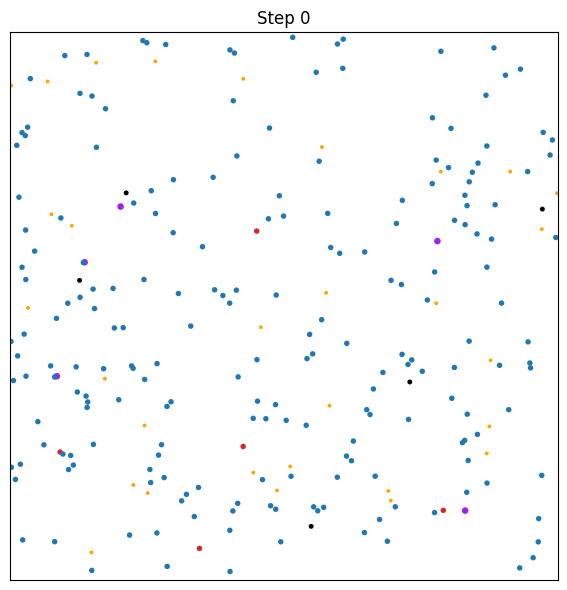

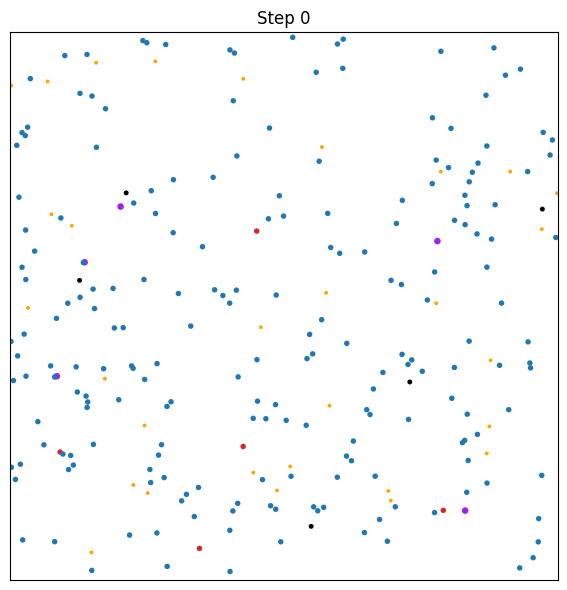

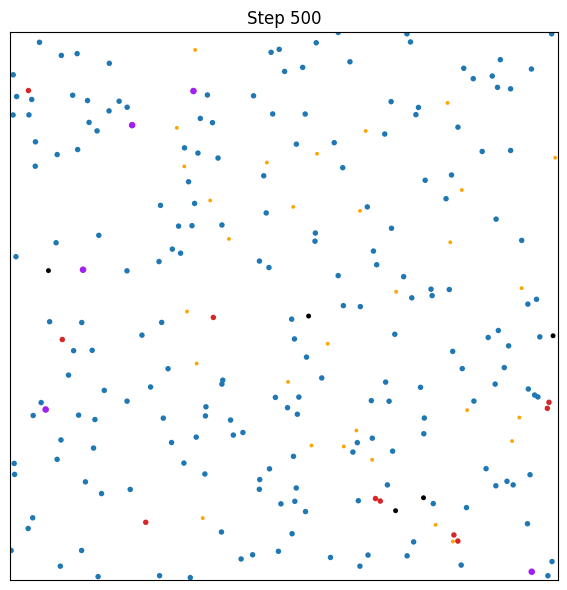

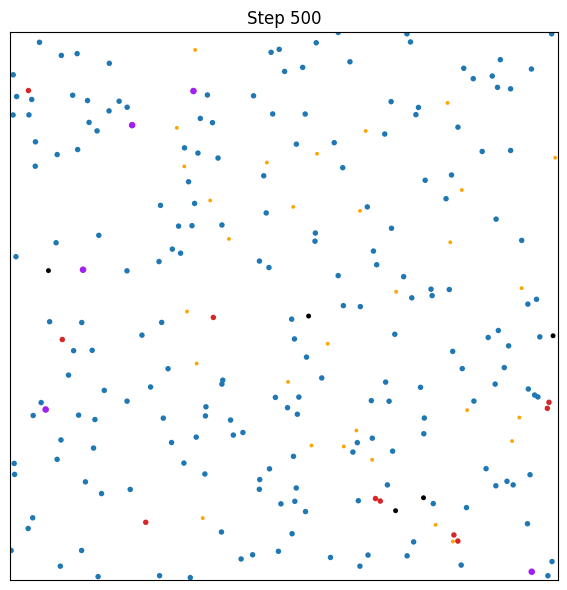

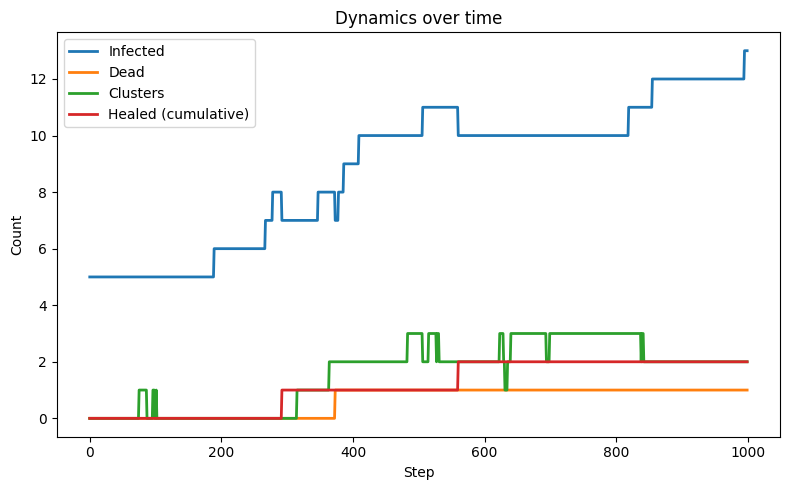

In [22]:

import numpy as np
import time
from tkinter import *
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from IPython.display import display

# snapshot settings
plot_steps = [0, 500, 1000,1500]


def plot_snapshot(x, y, status,
                  HSP104_idx, HEAL_idx, DEATH_idx,
                  radius_alpha_syn, radius_hsp104, radius_hsp70, radius_death,
                  L, step, window_size):

    fig, ax = plt.subplots(figsize=(6, 6))
    alive_idx = np.where(status != -1)[0]

    # calculate pixel → model unit
    unit_per_px = L / window_size

    for j in alive_idx:
        if j in HSP104_idx:
            color = '#A020F0'
            r_px = radius_hsp104
        elif j in HEAL_idx:
            color = '#FFA500'
            r_px = radius_hsp70
        elif j in DEATH_idx:
            color = '#000000'
            r_px = radius_death
        elif status[j] == 0:
            color = '#1f77b4'
            r_px = radius_alpha_syn
        elif status[j] == 1:
            color = '#d62728'
            r_px = radius_alpha_syn
        else:
            continue

        r_model = r_px * unit_per_px

        circ = Circle((x[j], y[j]), r_model,
                      facecolor=color, edgecolor='none')
        ax.add_patch(circ)

    ax.set_xlim(-L/2, L/2)
    ax.set_ylim(-L/2, L/2)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Step {step}")

    plt.tight_layout()
    plt.savefig(f"snapshot_step_{step:05d}.png", dpi=300)
    display(fig)
    plt.close(fig)

# logging of time series
step_history     = []
infected_history = []
dead_history     = []
cluster_history  = []
healed_history   = []
cumulative_healed = 0  

step = 0
N_max_steps = 1000

while running and step < N_max_steps:

    # snapshots
    if step in plot_steps:
        plot_snapshot(
            x, y, status,
            HSP104_idx, HEAL_idx, DEATH_idx,
            radius_alpha_syn, radius_hsp104,
            radius_hsp70, radius_death,
            L, step, window_size
        )

    infected_idx = np.where(status == 1)[0]
    alive_idx    = np.where(status != -1)[0]

    # log time series
    step_history.append(step)
    infected_history.append(np.sum(status == 1))
    dead_history.append(np.sum(status == -1))

    # amount of clusters = amount of cluster lists with at least 2 members
    n_clusters = len([c for c in clusters if len(c) >= 2])
    cluster_history.append(n_clusters)

    # cumulative amount that has become healthy via HEAL:
    healed_history.append(cumulative_healed)

    # snapshots
    if step in plot_steps:
        plot_snapshot(
            x, y, status,
            HSP104_idx, HEAL_idx, DEATH_idx,
            radius_alpha_syn, radius_hsp104,
            radius_hsp70, radius_death,
            L, step, window_size
        )

    # which infected are carried by HSP104
    carried_infected = np.array(
        [v[0] for v in following_hsp.values()],
        dtype=int
    ) if following_hsp else np.array([], dtype=int)

    infected_idx_for_dissociation = np.setdiff1d(
        infected_idx, carried_infected
    )

    # 1) Elastic collisions
    theta = collision_bounce(x, y, theta, Rf, L, alive_idx)

    # 2) DEATH-interaction
    theta, status = DEATH_interaction(
        x, y, theta,
        DEATH_idx,
        status, cluster_id,
        following_hsp,
        Rf, L, HSP104_idx,
        p_death
    )

    # 3) HEAL (HSP70)

    status_before_heal = status.copy()  # save pre-HEAL state
    theta, status = HEAL_interaction_bio(
        x, y, theta,
        HEAL_idx,
        status, cluster_id,
        Rf, L, dt
    )

    # count how many went from infected (1) → healthy (0) this step
    healed_this_step = np.sum((status_before_heal == 1) & (status == 0))
    cumulative_healed += healed_this_step


    # 4) Infected clusters
    theta = interaction_infected_clustering(
        x, y, theta,
        Rf, L,
        infected_idx_for_dissociation,
        cluster_range,
        status
    )

    # 5) HSP104 dissociation
    theta = HSP104_dissociation(
        theta, x, y,
        HSP104_idx,
        infected_idx_for_dissociation,
        HSP104_timer,
        max_dissociation_time,
        p_infected_drag,
        Rf, L,
        step
    )

    # 6) Update carried infected
    theta = update_following_hsp(
        theta, x, y,
        v, L,
        step,
        carry_duration=carry_duration
    )

    # 7) Infectionspread (bio)
    infected_idx = np.where(status == 1)[0]
    status = infection_spread_bio(
        x, y,
        status,
        infected_idx,
        infection_radius,
        dt,
        L,
        HSP104_idx,
        HEAL_idx,
        DEATH_idx
    )

    # 8) Noise in direction
    theta += eta * (np.random.rand(N_part) - 0.5)

    # 9) Active movement
    x[alive_idx] += v * np.cos(theta[alive_idx]) * dt
    y[alive_idx] += v * np.sin(theta[alive_idx]) * dt

    # 10) Brownian diffusion
    move_mask = (np.random.rand(N_part) < d_move) & (status != -1)
    dx = np.random.normal(0, sigma, size=N_part)
    dy = np.random.normal(0, sigma, size=N_part)
    x[move_mask] += dx[move_mask]
    y[move_mask] += dy[move_mask]

    # 11) Periodic boundaries
    x, y = pbc(x, y, L)

    # 12) Visualization
    if step % N_skip == 0:
        canvas.delete('all')
        alive_idx = np.where(status != -1)[0]
        for j in alive_idx:
            if j in HSP104_idx:
                color = '#A020F0'
                r = radius_hsp104
            elif j in HEAL_idx:
                color = '#FFA500'
                r = radius_hsp70
            elif j in DEATH_idx:
                color = '#000000'
                r = radius_death
            elif status[j] == 0:
                color = '#1f77b4'   # healthy
                r = radius_alpha_syn
            elif status[j] == 1:
                color = '#d62728'   # infected
                r = radius_alpha_syn
            else:
                continue

            cx = (x[j] + L/2) / L * window_size
            cy = (y[j] + L/2) / L * window_size
            canvas.create_oval(cx-r, cy-r, cx+r, cy+r,
                               outline='', fill=color)

        tk.update_idletasks()
        tk.update()

    step += 1
    if np.sum(status == 1) == 0:
        running = False

# plot graph over time series

plt.figure(figsize=(8, 5))
plt.plot(step_history, infected_history, label="Infected", linewidth=2)
plt.plot(step_history, dead_history,     label="Dead",     linewidth=2)
plt.plot(step_history, cluster_history,  label="Clusters", linewidth=2)
plt.plot(step_history, healed_history,   label="Healed (cumulative)", linewidth=2)


plt.xlabel("Step")
plt.ylabel("Count")
plt.title("Dynamics over time")
plt.legend()
plt.tight_layout()
plt.savefig("time_series_clusters_infected_dead.png", dpi=300)
plt.show()
